In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os, sys, math, time
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_fscore_support, accuracy_score
from collections import Counter
from torchvision.models import inception_v3
from torchvision import datasets


# For reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# for gpu usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# helper function to save figures
from torchvision.utils import make_grid
def show_grid(tensor, title=None, figsize=(8,8)):
    npimg = tensor.numpy()
    plt.figure(figsize=figsize)
    plt.axis('off')
    if title: plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

def save_grid(tensor, path, nrow=8):
    grid = make_grid(tensor, nrow=nrow, normalize=True, scale_each=True)

    npimg = grid.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.savefig(path, bbox_inches='tight', pad_inches=0)
    plt.close()

Device: cuda


In [2]:
# -----------------------------
#  Loading CIFAR-10 dataset
# We normalize  data to [-1,1]
# Also Added data augmentation for training.
# -----------------------------

DATA_DIR = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 2

# Training transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),                        # -> [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # -> [-1,1]
])

# Test transforms
transform_test = transforms.Compose([
    transforms.ToTensor(),                        # -> [0,1]
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  # -> [-1,1]
])

trainset = torchvision.datasets.CIFAR10(DATA_DIR, train=True, download=True, transform=transform_train)
testset  = torchvision.datasets.CIFAR10(DATA_DIR, train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=64,  shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Train size:", len(trainset), "Test size:", len(testset))

100%|██████████| 170M/170M [00:03<00:00, 48.1MB/s]


Train size: 50000 Test size: 10000


In [7]:
# -----------------------------
#  VAE model
# -----------------------------

class VAE(nn.Module):
    def __init__(self, latent_dim=512):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # 32x32 -> 16x16
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),  # 4x4 -> 2x2
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512 * 2 * 2, latent_dim)
        self.fc_logvar = nn.Linear(512 * 2 * 2, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 512 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # 4x4 -> 8x8
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 8x8 -> 16x16
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 16x16 -> 32x32
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, 1, 1),              # 32x32 -> 32x32
            nn.Tanh()  # Output in [-1,1]
        )

        # Applying Xavier initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, 512, 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# -----------------------------
# VAE loss
# MSE for reconstruction error a
# -----------------------------

def vae_loss(recon_x, x, mu, logvar, beta=4.0):
    recon_x = recon_x.view(recon_x.size(0), -1)
    x = x.view(x.size(0), -1)

    recon_loss = nn.MSELoss(reduction="sum")(recon_x, x) / x.size(0)  # Per-sample mean
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon_loss + beta * kl_loss
    return total, recon_loss, kl_loss

In [8]:
# -----------------------------
# Training Setup for VAE
# -----------------------------

vae = VAE(latent_dim=512).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

EPOCHS_VAE = 80
save_dir = "training_results"
os.makedirs(save_dir, exist_ok=True)

vae_total_hist, vae_recon_hist, vae_kl_hist = [], [], []

print("=== VAE training ")
for epoch in range(1, EPOCHS_VAE + 1):
    vae.train()
    running_total, running_recon, running_kl = 0.0, 0.0, 0.0

    # Gradual increases beta to 4.0 over 20 epochs
    beta = min(4.0, (epoch / 20.0) * 4.0)

    for imgs, _ in trainloader:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)
        loss, r_loss, kl = vae_loss(recon, imgs, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()

        running_total += loss.item()
        running_recon += r_loss.item()
        running_kl += kl.item()

    # Epoch averages
    n_batches = len(trainloader)
    epoch_total = running_total / n_batches
    vae_total_hist.append(epoch_total)
    vae_recon_hist.append(running_recon / n_batches)
    vae_kl_hist.append(running_kl / n_batches)

    # Step scheduler
    scheduler.step(epoch_total)

    print(f"VAE Epoch [{epoch}/{EPOCHS_VAE}]  Total: {vae_total_hist[-1]:.4f}  Recon: {vae_recon_hist[-1]:.4f}  KL: {vae_kl_hist[-1]:.4f}  Beta: {beta:.2f}")

# Saving VAE model
torch.save(vae.state_dict(), os.path.join(save_dir, "vae_final.pth"))

# Optional: Generate samples to verify diversity
def generate_samples(model, num_samples=1000, batch_size=128):
    model.eval()
    samples = []
    with torch.no_grad():
        for _ in range((num_samples + batch_size - 1) // batch_size):
            z = torch.randn(batch_size, 512, device=device)
            gen = model.decode(z)
            samples.append(gen.cpu())
    return torch.cat(samples, dim=0)[:num_samples]



=== VAE training 
VAE Epoch [1/80]  Total: 820.9668  Recon: 342.6365  KL: 2391.6515  Beta: 0.20
VAE Epoch [2/80]  Total: 141.8107  Recon: 140.7567  KL: 2.6349  Beta: 0.40
VAE Epoch [3/80]  Total: 116.0259  Recon: 114.2336  KL: 2.9871  Beta: 0.60
VAE Epoch [4/80]  Total: 103.7733  Recon: 101.2965  KL: 3.0959  Beta: 0.80
VAE Epoch [5/80]  Total: 96.1106  Recon: 93.0539  KL: 3.0567  Beta: 1.00
VAE Epoch [6/80]  Total: 90.9521  Recon: 87.4039  KL: 2.9568  Beta: 1.20
VAE Epoch [7/80]  Total: 86.9638  Recon: 82.9722  KL: 2.8511  Beta: 1.40
VAE Epoch [8/80]  Total: 83.6508  Recon: 79.2305  KL: 2.7627  Beta: 1.60
VAE Epoch [9/80]  Total: 81.3656  Recon: 76.5400  KL: 2.6809  Beta: 1.80
VAE Epoch [10/80]  Total: 78.4275  Recon: 73.2089  KL: 2.6093  Beta: 2.00
VAE Epoch [11/80]  Total: 76.5575  Recon: 70.9548  KL: 2.5467  Beta: 2.20
VAE Epoch [12/80]  Total: 74.5411  Recon: 68.5592  KL: 2.4924  Beta: 2.40
VAE Epoch [13/80]  Total: 72.6483  Recon: 66.3114  KL: 2.4373  Beta: 2.60
VAE Epoch [14/80] 

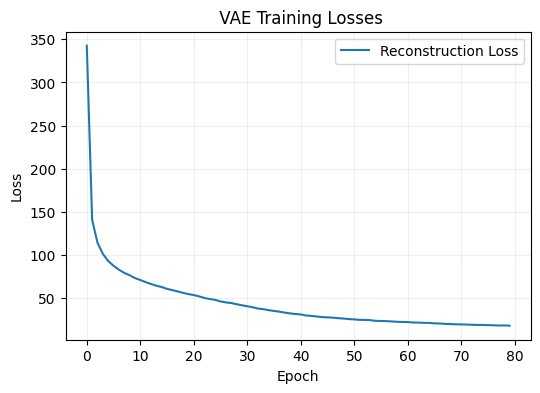

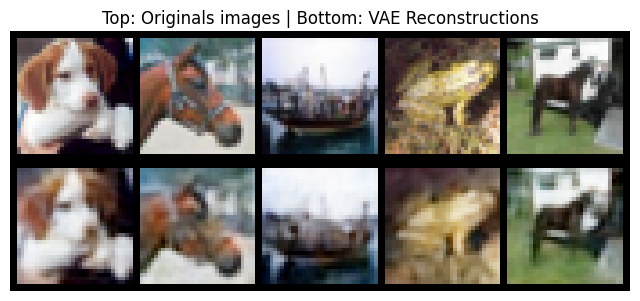

VAE: losses saved to training_results/vae_losses.png
VAE: reconstructions saved to training_results/vae_reconstructions.png


In [10]:
# Saving VAE loss plot
plt.figure(figsize=(6,4))
plt.plot(vae_recon_hist, label="Reconstruction Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(" VAE Training Losses")
plt.grid(alpha=0.2)
plt.savefig(os.path.join(save_dir, "vae_losses.png"))
plt.show()


vae.eval()
imgs, _ = next(iter(testloader))
# we convert the test image back to its original form to feed it to vae
imgs_v = (imgs + 1.0) / 2.0
imgs_v = imgs_v.to(device)
with torch.no_grad():
    recon_v, _, _ = vae(imgs_v)

# Now We'll create a grid where top row = original images from CIFAR-10 and bottom row = reconstructions
n_show = 21
orig_grid = make_grid(((imgs_v[16:n_show]).cpu()), nrow=5, normalize=False)
recon_grid = make_grid(recon_v[16:n_show].cpu(), nrow=5, normalize=False)

combined = torch.cat([orig_grid, recon_grid], dim=1)

show_grid(combined, title="Top: Originals images | Bottom: VAE Reconstructions")
# Saving final reconstructed images
save_grid(torch.cat([imgs_v[16:n_show].cpu(), recon_v[16:n_show].cpu()], dim=0), os.path.join(save_dir, "vae_reconstructions.png"), nrow=5)
print("VAE: losses saved to", os.path.join(save_dir,"vae_losses.png"))
print("VAE: reconstructions saved to", os.path.join(save_dir,"vae_reconstructions.png"))

In [11]:
# -----------------------------
# DCGAN model
# -----------------------------
# DCGAN hyperparams
nz = 100   # noise dim
ngf = 64   # generator feature maps base
ndf = 64   # discriminator feature maps base
nc = 3     # channels

# Generator:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # input: nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),
            # keep size 32x32, produce RGB
            nn.ConvTranspose2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()  # final output
        )

    def forward(self, z):
        return self.net(z)

# Discriminator:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            # 32x32 -> 16x16
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 16x16 -> 8x8
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),
            # 8x8 -> 4x4
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),
            # 4x4 -> 1x1
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).view(-1)

In [ ]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



# Initialize models
netG = Generator().to(device)
netG.apply(weights_init)
netD = Discriminator().to(device)
netD.apply(weights_init)

# Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))

g_losses, d_losses = [], []

# Fixed noise for consistent sample visualization
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

EPOCHS_GAN = 100
save_dir = "training_results"
os.makedirs(save_dir, exist_ok=True)

print("=== DCGAN training ===")
for epoch in range(1, EPOCHS_GAN+1):
    netG.train(); netD.train()
    epoch_g_loss, epoch_d_loss = 0.0, 0.0

    for i, (real_imgs, _) in enumerate(trainloader):
        b_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)

        # make real labels  0.9 and fake remains 0
        real_labels = torch.full((b_size,), 0.9, device=device)
        fake_labels = torch.zeros(b_size, device=device)

        # -------------------------
        # Updating D: maximize log(D(x)) + log(1 - D(G(z)))
        # -------------------------
        netD.zero_grad()
        out_real = netD(real_imgs)
        lossD_real = criterion(out_real, real_labels)

        # sample noise and generating fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs = netG(noise)
        out_fake = netD(fake_imgs.detach())
        lossD_fake = criterion(out_fake, fake_labels)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # -------------------------
        # Updating G: maximize log(D(G(z))) => minimize BCELoss(D(G(z)), 1)
        # -------------------------
        netG.zero_grad()
        out_fake_for_g = netD(fake_imgs)
        lossG = criterion(out_fake_for_g, real_labels)
        lossG.backward()
        optimizerG.step()

        epoch_g_loss += lossG.item()
        epoch_d_loss += lossD.item()

    # record epoch losses (average per batch)
    batches = len(trainloader)
    g_losses.append(epoch_g_loss / batches)
    d_losses.append(epoch_d_loss / batches)

    print(f"DCGAN Epoch [{epoch}/{EPOCHS_GAN}]  Loss_D: {d_losses[-1]:.4f}  Loss_G: {g_losses[-1]:.4f}")

# Saving DCGAN models
torch.save(netG.state_dict(), os.path.join(save_dir, "dcgan_G.pth"))
torch.save(netD.state_dict(), os.path.join(save_dir, "dcgan_D.pth"))

=== DCGAN training ===
DCGAN Epoch [1/100]  Loss_D: 0.8828  Loss_G: 3.1467
DCGAN Epoch [2/100]  Loss_D: 0.7297  Loss_G: 2.9112
DCGAN Epoch [3/100]  Loss_D: 0.7449  Loss_G: 2.6043
DCGAN Epoch [4/100]  Loss_D: 0.9817  Loss_G: 2.0197
DCGAN Epoch [5/100]  Loss_D: 0.9960  Loss_G: 1.8037
DCGAN Epoch [6/100]  Loss_D: 1.0722  Loss_G: 1.6160
DCGAN Epoch [7/100]  Loss_D: 1.1397  Loss_G: 1.4876
DCGAN Epoch [8/100]  Loss_D: 1.1749  Loss_G: 1.4062
DCGAN Epoch [9/100]  Loss_D: 1.1949  Loss_G: 1.3494
DCGAN Epoch [10/100]  Loss_D: 1.2031  Loss_G: 1.3099
DCGAN Epoch [11/100]  Loss_D: 1.1972  Loss_G: 1.3161
DCGAN Epoch [12/100]  Loss_D: 1.2157  Loss_G: 1.3406
DCGAN Epoch [13/100]  Loss_D: 1.2048  Loss_G: 1.2815
DCGAN Epoch [14/100]  Loss_D: 1.2121  Loss_G: 1.2580
DCGAN Epoch [15/100]  Loss_D: 1.2156  Loss_G: 1.2463
DCGAN Epoch [16/100]  Loss_D: 1.2140  Loss_G: 1.2363
DCGAN Epoch [17/100]  Loss_D: 1.2342  Loss_G: 1.2385
DCGAN Epoch [18/100]  Loss_D: 1.2288  Loss_G: 1.2167
DCGAN Epoch [19/100]  Loss_D: 1.

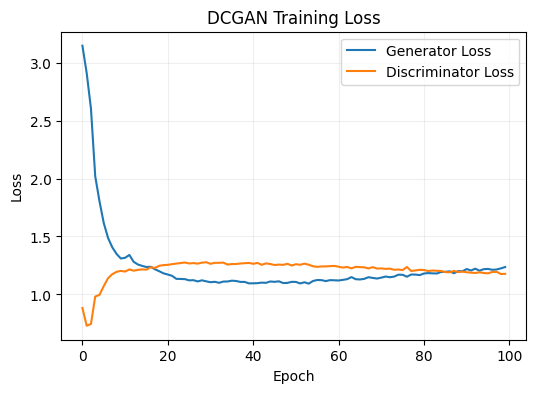

In [ ]:
# Save DCGAN loss plot
plt.figure(figsize=(6,4))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("DCGAN Training Loss")
plt.grid(alpha=0.2)
plt.savefig(os.path.join(save_dir, "dcgan_losses.png"))
plt.show()


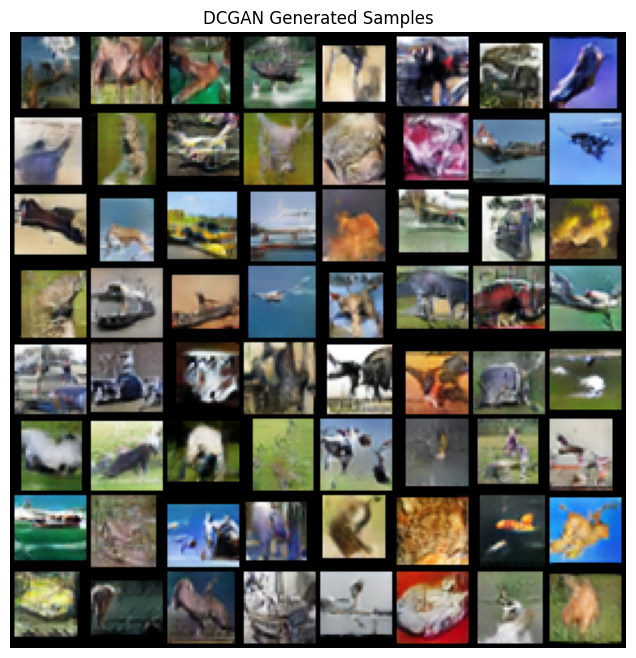

DCGAN: generated samples saved to training_results/dcgan_generated.png


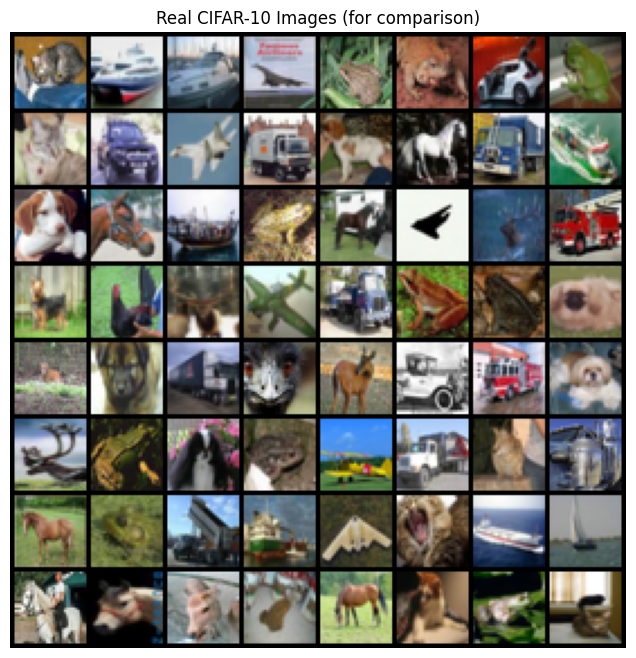

DCGAN: real examples saved to training_results/dcgan_real_examples.png


In [ ]:
# Generating final samples
netG.eval()
with torch.no_grad():
    fake_samples = netG(fixed_noise).cpu()  # in [-1,1]

# visualizing generated images
show_grid(make_grid(fake_samples, nrow=8, normalize=True), title="DCGAN Generated Samples")
save_grid(fake_samples, os.path.join(save_dir, "dcgan_generated.png"), nrow=8)
print("DCGAN: generated samples saved to", os.path.join(save_dir,"dcgan_generated.png"))

#  real images for comparison
real_batch = next(iter(testloader))[0]  # test images
show_grid(make_grid(real_batch[:64].cpu(), nrow=8, normalize=True), title="Real CIFAR-10 Images (for comparison)")
save_grid(real_batch[:64].cpu(), os.path.join(save_dir, "dcgan_real_examples.png"), nrow=8)
print("DCGAN: real examples saved to", os.path.join(save_dir,"dcgan_real_examples.png"))

In [12]:
# Checkpoint/default paths

vae_ckpt = "/content/training_results/vae_final.pth"
ganG_ckpt = "/content/training_results/dcgan_G.pth"

print("Auto-detected VAE checkpoint:", vae_ckpt)
print("Auto-detected GAN generator checkpoint:", ganG_ckpt)

SAVE_DIR = "step2_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)


# ---------- Load checkpoints ----------
vae = VAE().to(device)
if vae_ckpt is not None:
    try:
        vae.load_state_dict(torch.load(vae_ckpt, map_location=device))
        print("Loaded VAE from", vae_ckpt)
    except Exception as e:
        print("Failed loading VAE:", e)

G = Generator().to(device)
if ganG_ckpt is not None:
    try:
        G.load_state_dict(torch.load(ganG_ckpt, map_location=device))
        print("Loaded Generator from", ganG_ckpt)
    except Exception as e:
        print("Failed loading Generator:", e)

vae.eval(); G.eval()

# ----------  helper function ----------
def denorm_img_tensor(img_tensor):
    """
    To convert normalized image back to its original form
    """
    if img_tensor.min() < -0.1:
        return (img_tensor + 1.0) / 2.0
    else:
        return img_tensor



Auto-detected VAE checkpoint: /content/training_results/vae_final.pth
Auto-detected GAN generator checkpoint: /content/training_results/dcgan_G.pth
Loaded VAE from /content/training_results/vae_final.pth
Loaded Generator from /content/training_results/dcgan_G.pth


### Visual Quality

Saved: step2_outputs/orig_vs_vae_vs_gan.png


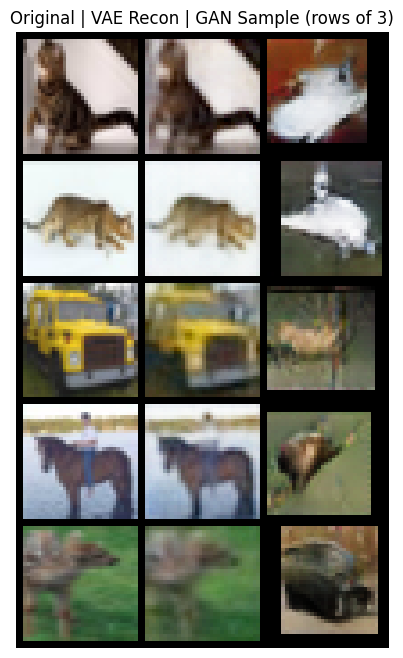

In [27]:
#  Visual comparison of (Original | VAE reconstructions | GAN sample)

n_samples = 5         # number of  images to compare
filename = "orig_vs_vae_vs_gan.png"

# getting a random batch with at least n_samples
loader = torch.utils.data.DataLoader(testset, batch_size=n_samples, shuffle=True)
imgs, _ = next(iter(loader))
imgs = imgs[:n_samples]

# Preparing VAE input
imgs_01 = denorm_img_tensor(imgs).to(device)

# VAE reconstruction
vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(imgs_01)
    recon = vae.decode(mu)

# To Generate GAN samples
G.eval()
with torch.no_grad():
    z = torch.randn(n_samples, nz, 1, 1, device=device)
    gan_out = G(z).cpu()
    gan_out_01 = denorm_img_tensor(gan_out)

# original vs vae reconstruction vs gan generation for each sample
assembled = []
for i in range(n_samples):
    assembled.append(denorm_img_tensor(imgs[i]).cpu())
    assembled.append(recon[i].cpu())
    assembled.append(gan_out_01[i])

batch = torch.stack(assembled, dim=0)

# Save grid and show
save_grid(batch, os.path.join(SAVE_DIR, filename), nrow=3)
print("Saved:", os.path.join(SAVE_DIR, filename))

# preparing a grid arranged in three rows to show the comparison of images
grid = make_grid(batch, nrow=3, normalize=False)
show_grid(grid, title="Original | VAE Recon | GAN Sample (rows of 3)")

###  Diversity

Classifier epoch 1 loss: 2.0309
Classifier epoch 2 loss: 1.4631
Classifier epoch 3 loss: 1.2624
Classifier epoch 4 loss: 1.1287
Classifier epoch 5 loss: 1.0350
Classifier epoch 6 loss: 0.9759
Classifier epoch 7 loss: 0.9261
Classifier epoch 8 loss: 0.8851
Classifier epoch 9 loss: 0.8554
Classifier epoch 10 loss: 0.8287
Saved CIFAR classifier to step2_outputs/cifar_clf.pth
GAN Class Distribution: {'deer': 121, 'cat': 375, 'ship': 26, 'plane': 224, 'horse': 64, 'bird': 57, 'car': 58, 'truck': 32, 'frog': 22, 'dog': 21}
Unique GAN Classes: 10
VAE Generated Class Distribution: {'dog': 55, 'deer': 39, 'truck': 321, 'cat': 475, 'car': 62, 'plane': 20, 'horse': 26, 'frog': 2}
Unique VAE Generated Classes: 8
VAE Reconstruction Class Distribution: {'cat': 365, 'ship': 55, 'plane': 139, 'deer': 176, 'car': 65, 'truck': 34, 'dog': 29, 'horse': 69, 'frog': 23, 'bird': 45}
Unique VAE Reconstruction Classes: 10


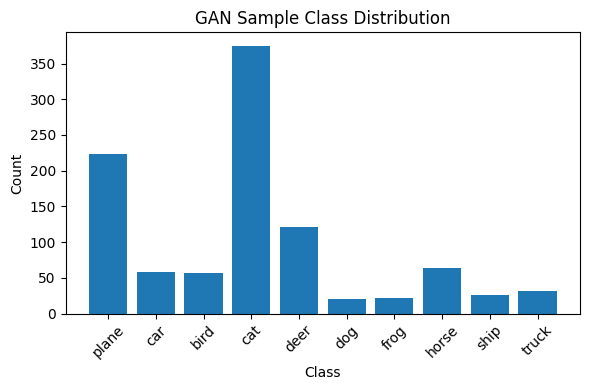

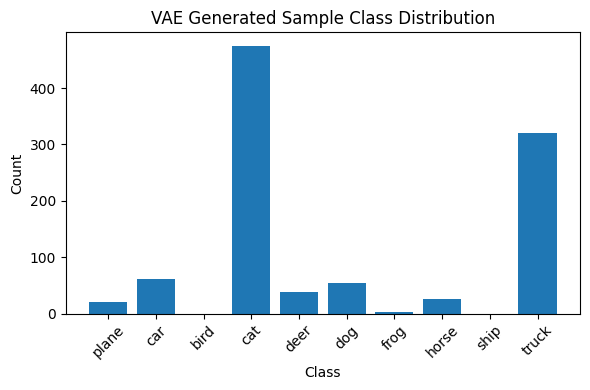

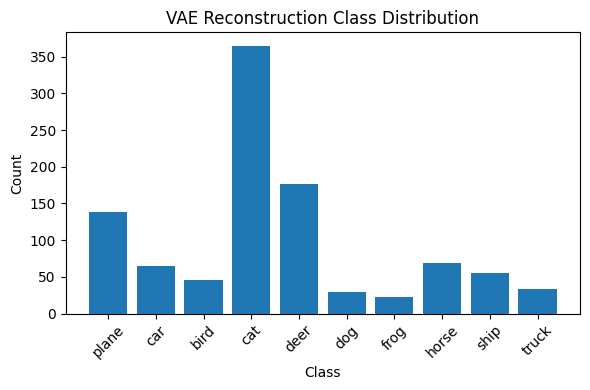

In [30]:
# CIFAR-10 classifier
TRAIN_CIFAR_CLF = True

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# -----------------------------
#  Training the vlassifier
# -----------------------------
if TRAIN_CIFAR_CLF:

    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])

    # Loading CIFAR-10 dataset
    trainset_clf = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=train_transform)
    trainloader_clf = DataLoader(trainset_clf, batch_size=128, shuffle=True, num_workers=2)

    clf = torchvision.models.resnet18(num_classes=10).to(device)
    opt = optim.SGD(clf.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

    for epoch in range(10):
        clf.train()
        running_loss = 0.0
        for imgs, labels in trainloader_clf:
            imgs, labels = imgs.to(device), labels.to(device)
            opt.zero_grad()
            logits = clf(imgs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        print(f"Classifier epoch {epoch+1} loss: {running_loss / len(trainloader_clf):.4f}")

    # Save classifier
    torch.save(clf.state_dict(), os.path.join(SAVE_DIR, "cifar_clf.pth"))
    print(f"Saved CIFAR classifier to {os.path.join(SAVE_DIR, 'cifar_clf.pth')}")
else:
    clf = torchvision.models.resnet18(num_classes=10).to(device)
    clf.load_state_dict(torch.load(os.path.join(SAVE_DIR, "cifar_clf.pth")))
    print("Loaded pre-trained CIFAR classifier.")

clf.eval()


# -----------------------------
# Generating 1000 Samples
# -----------------------------
num_samples = 1000
batch_size = 128

# GAN Samples
gan_samples = []
with torch.no_grad():
    for _ in range((num_samples + batch_size - 1) // batch_size):
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = G(noise)
        gan_samples.append(fake.cpu())
gan_samples = torch.cat(gan_samples, dim=0)[:num_samples]

# VAE Generated Samples
vae_samples = []
with torch.no_grad():
    for _ in range((num_samples + batch_size - 1) // batch_size):
        z = torch.randn(batch_size, 512, device=device)
        gen = vae.decode(z)
        vae_samples.append(gen.cpu())
vae_samples = torch.cat(vae_samples, dim=0)[:num_samples]

# VAE Reconstructions
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = DataLoader(testset, batch_size=num_samples, shuffle=False, num_workers=2)
test_imgs, _ = next(iter(testloader))
test_imgs = test_imgs.to(device)
with torch.no_grad():
    vae_recons, _, _ = vae(test_imgs)
vae_recons = vae_recons.cpu()

# Saving sample grids
vutils.save_image(gan_samples, os.path.join(SAVE_DIR, "gan_samples_1000.png"), nrow=32, normalize=True)
vutils.save_image(vae_samples, os.path.join(SAVE_DIR, "vae_generated_1000.png"), nrow=32, normalize=True)
vutils.save_image(vae_recons, os.path.join(SAVE_DIR, "vae_reconstructions_1000.png"), nrow=32, normalize=True)

# -----------------------------
# Prediction of Classes
# -----------------------------
def get_class_distribution(samples, model, device, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(0, len(samples), batch_size):
            batch = samples[i:i+batch_size].to(device)
            batch_norm = (batch - torch.tensor(mean, device=device).view(1, 3, 1, 1)) / \
                         torch.tensor(std, device=device).view(1, 3, 1, 1)
            logits = model(batch_norm)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
    dist = dict(Counter([classes[p] for p in predictions]))
    return dist, len(set(predictions))

# GAN Distribution
gan_dist, gan_unique = get_class_distribution(gan_samples, clf, device)
print("GAN Class Distribution:", gan_dist)
print("Unique GAN Classes:", gan_unique)

# VAE Generated Distribution
vae_gen_dist, vae_gen_unique = get_class_distribution(vae_samples, clf, device)
print("VAE Generated Class Distribution:", vae_gen_dist)
print("Unique VAE Generated Classes:", vae_gen_unique)

# VAE Reconstruction Distribution
vae_recon_dist, vae_recon_unique = get_class_distribution(vae_recons, clf, device)
print("VAE Reconstruction Class Distribution:", vae_recon_dist)
print("Unique VAE Reconstruction Classes:", vae_recon_unique)

# -----------------------------
#  Plotting the Distributions
# -----------------------------
def plot_distribution(dist, title):
    labels = classes
    counts = [dist.get(label, 0) for label in labels]
    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"{title.replace(' ', '_')}.png"))
    plt.show()
    plt.close()

plot_distribution(gan_dist, "GAN Sample Class Distribution")
plot_distribution(vae_gen_dist, "VAE Generated Sample Class Distribution")
plot_distribution(vae_recon_dist, "VAE Reconstruction Class Distribution")

### Metrics

VAE: mean per-image MSE over test set = 0.001980


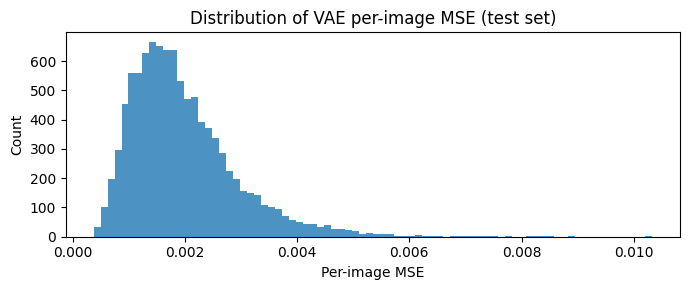

Saved histogram to step2_outputs/vae_mse_hist.png


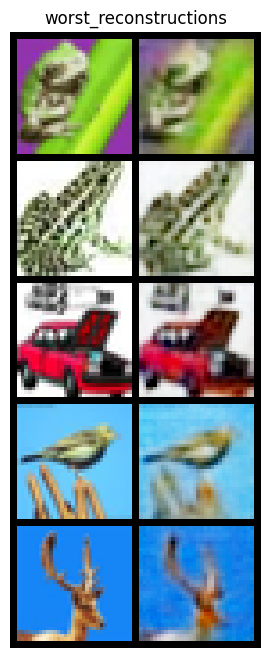

Saved worst reconstructions grid to step2_outputs/vae_pairs_worst_reconstructions.png


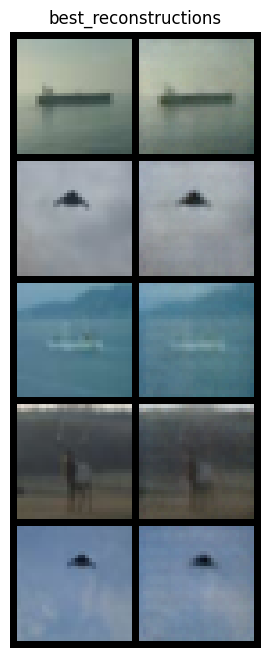

Saved best reconstructions grid to step2_outputs/vae_pairs_best_reconstructions.png


In [31]:
#  VAE reconstruction MSE on the full test set

vae.eval()
mse_list = []
orig_images_all = []
recon_images_all = []

with torch.no_grad():
    for imgs, _ in testloader:
        imgs01 = denorm_img_tensor(imgs).to(device)
        mu, _ = vae.encode(imgs01)
        recon = vae.decode(mu)
        # per-image MSE (mean over pixels & channels)
        per_mse = ((recon - imgs01)**2).view(imgs01.size(0), -1).mean(dim=1).cpu().numpy()
        mse_list.append(per_mse)
        orig_images_all.append(imgs01.cpu())
        recon_images_all.append(recon.cpu())


mse_arr = np.concatenate(mse_list, axis=0)
orig_images_all = torch.cat(orig_images_all, dim=0)
recon_images_all = torch.cat(recon_images_all, dim=0)

mean_mse = mse_arr.mean()
print(f"VAE: mean per-image MSE over test set = {mean_mse:.6f}")


plt.figure(figsize=(7,3))
plt.hist(mse_arr, bins=80, color='tab:blue', alpha=0.8)
plt.xlabel("Per-image MSE")
plt.ylabel("Count")
plt.title("Distribution of VAE per-image MSE (test set)")
plt.tight_layout()
hist_path = os.path.join(SAVE_DIR, "vae_mse_hist.png")
plt.savefig(hist_path)
plt.show()
print("Saved histogram to", hist_path)

# To Show worst and best reconstructions
k = 5
worst_idx = np.argsort(-mse_arr)[:k]
best_idx  = np.argsort(mse_arr)[:k]

# Helper to display a small grid of originals and reconstructions side by side
def show_pairs(indices, title):
    pair_list = []
    for idx in indices:
        pair_list.append(orig_images_all[idx])
        pair_list.append(recon_images_all[idx])
    batch_pairs = torch.stack(pair_list, dim=0)
    save_grid(batch_pairs, os.path.join(SAVE_DIR, f"vae_pairs_{title}.png"), nrow=2)
    grid = make_grid(batch_pairs, nrow=2, normalize=False)
    show_grid(grid, title=title)

show_pairs(worst_idx, "worst_reconstructions")
print("Saved worst reconstructions grid to", os.path.join(SAVE_DIR, "vae_pairs_worst_reconstructions.png"))

show_pairs(best_idx, "best_reconstructions")
print("Saved best reconstructions grid to", os.path.join(SAVE_DIR, "vae_pairs_best_reconstructions.png"))

In [32]:
sample_count = 1000   # number of GAN samples (adjust for speed/accuracy)
batch_size = 64

# Load Inception v3 for logits
inc_logits = inception_v3(pretrained=True, aux_logits=True)
inc_logits.to(device).eval()

# Preprocess (same as before)
imagenet_mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
imagenet_std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
def preprocess_for_inception(tensor01):
    x = F.interpolate(tensor01.to(device), size=(299,299), mode='bilinear', align_corners=False)
    x = (x - imagenet_mean) / imagenet_std
    return x

# Generate GAN samples
G.eval()
gan_samples = []
with torch.no_grad():
    for i in range(0, sample_count, batch_size):
        b = min(batch_size, sample_count - i)
        z = torch.randn(b, nz, 1, 1, device=device)
        imgs_gen = G(z).cpu()
        gan_samples.append(denorm_img_tensor(imgs_gen))   # [-1,1] -> [0,1]
gan_images01 = torch.cat(gan_samples, dim=0)[:sample_count]

# Get Inception logits
def get_logits_from_tensor(images01, model_logits, batch_size=32):
    logits_list = []
    with torch.no_grad():
        for i in range(0, images01.size(0), batch_size):
            b = images01[i:i+batch_size]
            b_pre = preprocess_for_inception(b)
            logits = model_logits(b_pre).cpu().numpy()
            logits_list.append(logits)
    return np.concatenate(logits_list, axis=0)

gan_logits = get_logits_from_tensor(gan_images01, inc_logits, batch_size=32)

# Compute IS
def inception_score_from_logits(logits, splits=10):
    probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
    N = probs.shape[0]; split_scores = []
    for k in range(splits):
        part = probs[k*(N//splits):(k+1)*(N//splits)]
        py = np.mean(part, axis=0)
        kl = part * (np.log(part + 1e-10) - np.log(py + 1e-10))
        split_scores.append(np.exp(np.mean(np.sum(kl, axis=1))))
    return float(np.mean(split_scores)), float(np.std(split_scores))

is_gan_mean, is_gan_std = inception_score_from_logits(gan_logits, splits=10)
print(f"Inception Score (GAN): {is_gan_mean:.3f} ± {is_gan_std:.3f}")

# Save a grid of samples for visualization
from torchvision.utils import make_grid
save_grid(gan_images01[:64], os.path.join(SAVE_DIR, "gan_is_samples.png"), nrow=8)
print("Saved GAN sample grid for IS visualization.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 189MB/s] 


Inception Score (GAN): 3.997 ± 0.195
Saved GAN sample grid for IS visualization.


## Latent Space Structure

### Interpolation

VAE interpolation chosen classes: [8 1] indices: 1 6
Saved VAE interpolation grid to step2_outputs/vae_interpolation.png


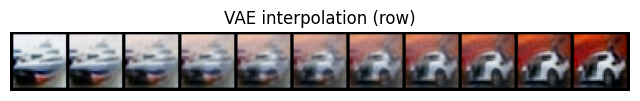

VAE avg step MSE between consecutive interpolated frames: 0.002675
Saved GAN interpolation grid to step2_outputs/gan_interpolation.png


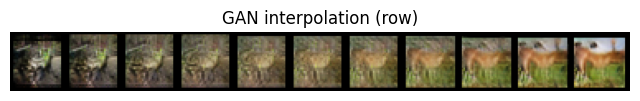

GAN avg step MSE between consecutive interpolated frames: 0.004983
Summary (lower avg step MSE => smoother transitions):
  VAE avg step MSE: 0.002675
  GAN avg step MSE: 0.004983


In [33]:
# Interpolation for VAE and GAN


os.makedirs(SAVE_DIR, exist_ok=True)

# computing per-step MSE for a sequence of images
def avg_step_mse(imgs_seq):
    diffs = (imgs_seq[1:] - imgs_seq[:-1]).reshape(imgs_seq.size(0)-1, -1)
    per_step_mse = (diffs**2).mean(dim=1).cpu().numpy()
    return per_step_mse.mean(), per_step_mse  # mean and array

# parameters
n_steps = 11
n_show = n_steps

# ---- choose two test images from different classes ----

labels = np.array([testset[i][1] for i in range(len(testset))])

cls = np.random.choice(np.unique(labels), size=2, replace=False)

idx1 = int(np.where(labels == cls[0])[0][0])
idx2 = int(np.where(labels == cls[1])[0][0])
print("VAE interpolation chosen classes:", cls, "indices:", idx1, idx2)

# load images in original shape
img1, _ = testset[idx1]
img2, _ = testset[idx2]
img1 = img1.unsqueeze(0)
img2 = img2.unsqueeze(0)

img1_01 = denorm_img_tensor(img1).to(device)
img2_01 = denorm_img_tensor(img2).to(device)

vae.eval()
with torch.no_grad():
    mu1, _ = vae.encode(img1_01)
    mu2, _ = vae.encode(img2_01)

# linear interpolation
alphas = torch.linspace(0, 1, steps=n_steps, device=device)
z_interp = [(1-a)*mu1 + a*mu2 for a in alphas]
z_interp = torch.cat(z_interp, dim=0)
with torch.no_grad():
    recon_interp = vae.decode(z_interp)
# move to CPU
recon_interp_cpu = recon_interp.cpu()

# VAE interpolation grid
vae_interp_fname = os.path.join(SAVE_DIR, "vae_interpolation.png")
save_grid(recon_interp_cpu, vae_interp_fname, nrow=n_show)
print("Saved VAE interpolation grid to", vae_interp_fname)
show_grid(make_grid(recon_interp_cpu, nrow=n_show, normalize=False), title="VAE interpolation (row)")

# computing average step MSE for VAE
vae_step_mean, vae_step_arr = avg_step_mse(recon_interp_cpu)
print(f"VAE avg step MSE between consecutive interpolated frames: {vae_step_mean:.6f}")

# ---- Take two random latent vectors ----

G.eval()
with torch.no_grad():
    z1 = torch.randn(1, nz, 1, 1, device=device)
    z2 = torch.randn(1, nz, 1, 1, device=device)
    z_interp_g = [(1-a)*z1 + a*z2 for a in alphas]
    z_interp_g = torch.cat(z_interp_g, dim=0)  # (n_steps, nz, 1,1)
    gan_interp = G(z_interp_g).cpu()            # in [-1,1]
    gan_interp_01 = denorm_img_tensor(gan_interp)  # to [0,1]

# GAN interpolation grid
gan_interp_fname = os.path.join(SAVE_DIR, "gan_interpolation.png")
save_grid(gan_interp_01, gan_interp_fname, nrow=n_show)
print("Saved GAN interpolation grid to", gan_interp_fname)
show_grid(make_grid(gan_interp_01, nrow=n_show, normalize=False), title="GAN interpolation (row)")

# compute average step MSE for GAN
gan_step_mean, gan_step_arr = avg_step_mse(gan_interp_01)
print(f"GAN avg step MSE between consecutive interpolated frames: {gan_step_mean:.6f}")

# ---- quantitative comparison  ----
print("Summary (lower avg step MSE => smoother transitions):")
print(f"  VAE avg step MSE: {vae_step_mean:.6f}")
print(f"  GAN avg step MSE: {gan_step_mean:.6f}")

### Latent representation analysis for VAE (PCA + t-SNE)

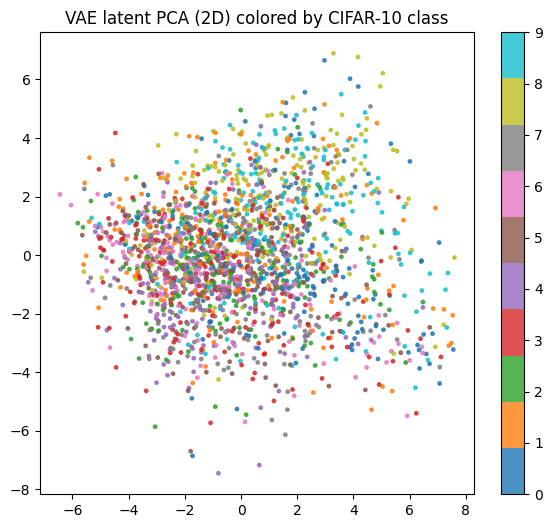

Saved PCA plot to step2_outputs/vae_latent_pca2d.png
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 3.013740


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.002129
[t-SNE] KL divergence after 1000 iterations: 2.377934


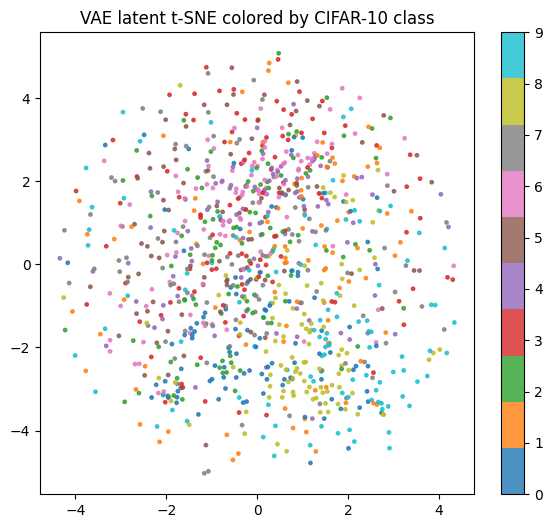

Saved t-SNE plot to step2_outputs/vae_latent_tsne2d.png
Saved VAE PCA coords to CSV.


In [34]:
vae.eval()

# parameters:
N_pca = 2000   # for PCA
N_tsne = 1000  # for t-SNE

mus = []
labs = []
collected = 0
with torch.no_grad():
    for imgs, labels in DataLoader(testset, batch_size=128, shuffle=False):
        imgs01 = denorm_img_tensor(imgs).to(device)
        mu, _ = vae.encode(imgs01)
        mus.append(mu.cpu().numpy())
        labs.append(labels.numpy())
        collected += imgs.size(0)
        if collected >= max(N_pca, N_tsne):
            break

mus = np.concatenate(mus, axis=0)
labs = np.concatenate(labs, axis=0)

mus_pca = mus[:N_pca]
labs_pca = labs[:N_pca]
mus_tsne = mus[:N_tsne]
labs_tsne = labs[:N_tsne]

# PCA
pca = PCA(n_components=2)
mus_pca_2d = pca.fit_transform(mus_pca)
plt.figure(figsize=(7,6))
scatter = plt.scatter(mus_pca_2d[:,0], mus_pca_2d[:,1], c=labs_pca, cmap='tab10', s=6, alpha=0.8)
plt.title("VAE latent PCA (2D) colored by CIFAR-10 class")
plt.colorbar(scatter, ticks=range(10))
pca_path = os.path.join(SAVE_DIR, "vae_latent_pca2d.png")
plt.savefig(pca_path, bbox_inches='tight', dpi=150)
plt.show()
print("Saved PCA plot to", pca_path)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=1, init='pca', random_state=42)
mus_tsne_2d = tsne.fit_transform(mus_tsne)
plt.figure(figsize=(7,6))
scatter = plt.scatter(mus_tsne_2d[:,0], mus_tsne_2d[:,1], c=labs_tsne, cmap='tab10', s=6, alpha=0.8)
plt.title("VAE latent t-SNE colored by CIFAR-10 class")
plt.colorbar(scatter, ticks=range(10))
tsne_path = os.path.join(SAVE_DIR, "vae_latent_tsne2d.png")
plt.savefig(tsne_path, bbox_inches='tight', dpi=150)
plt.show()
print("Saved t-SNE plot to", tsne_path)

#  PCA coords + labels to CSV
import pandas as pd
df_pca = pd.DataFrame({
    "pc1": mus_pca_2d[:,0],
    "pc2": mus_pca_2d[:,1],
    "label": labs_pca
})
df_pca.to_csv(os.path.join(SAVE_DIR, "vae_pca_coords.csv"), index=False)
print("Saved VAE PCA coords to CSV.")

### Semantic Factors

Top dims by latent std: [47, 61, 483, 383]
Saved traversal along latent dim 47 -> step2_outputs/vae_vary_dim_47.png


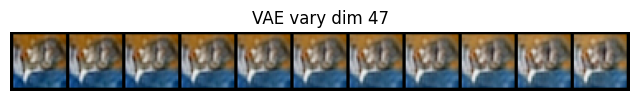

Saved traversal along latent dim 61 -> step2_outputs/vae_vary_dim_61.png


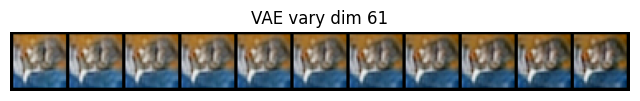

Saved traversal along latent dim 483 -> step2_outputs/vae_vary_dim_483.png


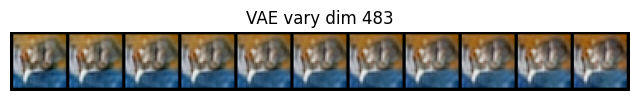

Saved traversal along latent dim 383 -> step2_outputs/vae_vary_dim_383.png


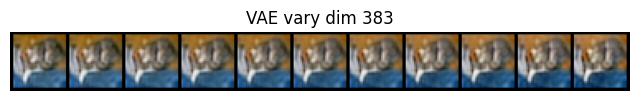

Saved traversal along PC 0 -> step2_outputs/vae_vary_pc_0.png


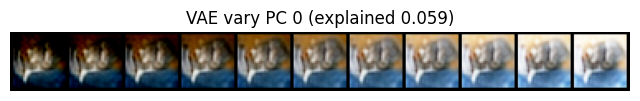

Saved traversal along PC 1 -> step2_outputs/vae_vary_pc_1.png


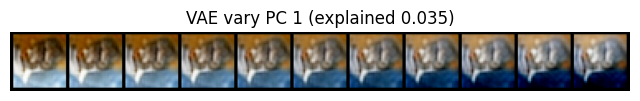

Saved traversal along PC 2 -> step2_outputs/vae_vary_pc_2.png


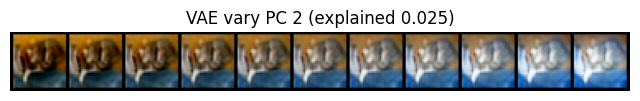

Saved GAN traversal along z[0] -> step2_outputs/gan_vary_zcoord_0.png


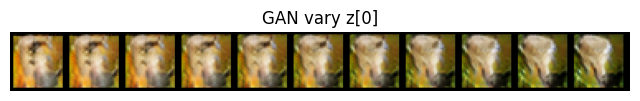

Saved GAN traversal along z[1] -> step2_outputs/gan_vary_zcoord_1.png


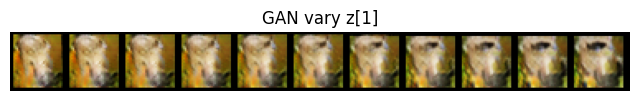

Saved GAN traversal along z[2] -> step2_outputs/gan_vary_zcoord_2.png


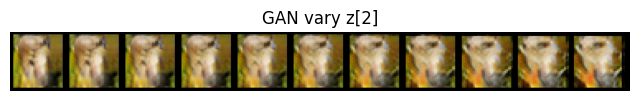

Saved GAN traversal along z[3] -> step2_outputs/gan_vary_zcoord_3.png


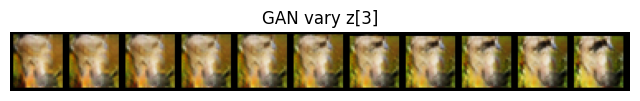

Semantic traversals saved in step2_outputs


In [35]:
os.makedirs(SAVE_DIR, exist_ok=True)

# --- Compute latent statistics (mean & std) over test set ---
vae.eval()
M_stats = 2000
mus_stats, count = [], 0
with torch.no_grad():
    for imgs, _ in DataLoader(testset, batch_size=128, shuffle=False):
        imgs01 = denorm_img_tensor(imgs).to(device)
        mu, _ = vae.encode(imgs01)
        mus_stats.append(mu.cpu().numpy())
        count += imgs.size(0)
        if count >= M_stats:
            break

mus_stats = np.concatenate(mus_stats, axis=0)[:M_stats]
mu_mean = mus_stats.mean(axis=0)
mu_std  = mus_stats.std(axis=0)
latent_dim = mus_stats.shape[1]

# Pick one image to use as a starting point
base_img, _ = testset[0]
base_img_01 = denorm_img_tensor(base_img.unsqueeze(0)).to(device)
with torch.no_grad():
    base_mu, _ = vae.encode(base_img_01)
base_mu = base_mu.squeeze(0).cpu().numpy()

# --- Vary individual latent dimensions with highest variance ---
topk = 4
top_dims = np.argsort(-mu_std)[:topk]
print("Top dims by latent std:", top_dims.tolist())

n_steps = 11
alphas = np.linspace(-3.0, 3.0, n_steps)

for dim in top_dims:
    varied = []
    for a in alphas:
        z = base_mu.copy()
        z[dim] = base_mu[dim] + a * mu_std[dim]
        z_t = torch.tensor(z, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            img = vae.decode(z_t)
        varied.append(img.squeeze(0).cpu())
    batch_var = torch.stack(varied, dim=0)
    fname = os.path.join(SAVE_DIR, f"vae_vary_dim_{dim}.png")
    save_grid(batch_var, fname, nrow=n_steps)
    print(f"Saved traversal along latent dim {dim} -> {fname}")
    show_grid(make_grid(batch_var, nrow=n_steps), title=f"VAE vary dim {dim}")

# --- Vary along PCA directions of latent space ---
from sklearn.decomposition import PCA
pca_full = PCA(n_components=10).fit(mus_stats)
pc_dirs = pca_full.components_
pc_explained = pca_full.explained_variance_ratio_

for k in range(3):
    dir_vec = pc_dirs[k]
    dir_std = np.sqrt(pca_full.explained_variance_[k])
    varied = []
    for a in alphas:
        z = base_mu + a * dir_std * dir_vec
        z_t = torch.tensor(z, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            img = vae.decode(z_t)
        varied.append(img.squeeze(0).cpu())
    batch_var = torch.stack(varied, dim=0)
    fname = os.path.join(SAVE_DIR, f"vae_vary_pc_{k}.png")
    save_grid(batch_var, fname, nrow=n_steps)
    print(f"Saved traversal along PC {k} -> {fname}")
    show_grid(make_grid(batch_var, nrow=n_steps), title=f"VAE vary PC {k} (explained {pc_explained[k]:.3f})")

# --- GAN: vary individual latent coordinates ---
G.eval()
z_base = torch.randn(1, nz, 1, 1, device=device)
z_base_cpu = z_base.squeeze(0).cpu().numpy()

gan_coords = [0, 1, 2, 3]
alphas = np.linspace(-3, 3, n_steps)

for coord in gan_coords:
    imgs_vary = []
    for a in alphas:
        z = z_base_cpu.copy()
        z[coord] = z_base_cpu[coord] + a
        z_t = torch.tensor(z, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            img = G(z_t).cpu()
            img01 = denorm_img_tensor(img)
        imgs_vary.append(img01.squeeze(0))
    batch_var = torch.stack(imgs_vary, dim=0)
    fname = os.path.join(SAVE_DIR, f"gan_vary_zcoord_{coord}.png")
    save_grid(batch_var, fname, nrow=n_steps)
    print(f"Saved GAN traversal along z[{coord}] -> {fname}")
    show_grid(make_grid(batch_var, nrow=n_steps), title=f"GAN vary z[{coord}]")

print("Semantic traversals saved in", SAVE_DIR)

## Out-of-Distribution

### VAE OOD reconstruction

100%|██████████| 169M/169M [00:04<00:00, 39.9MB/s]
100%|██████████| 64.3M/64.3M [00:03<00:00, 21.2MB/s]


Computing VAE reconstruction MSE...


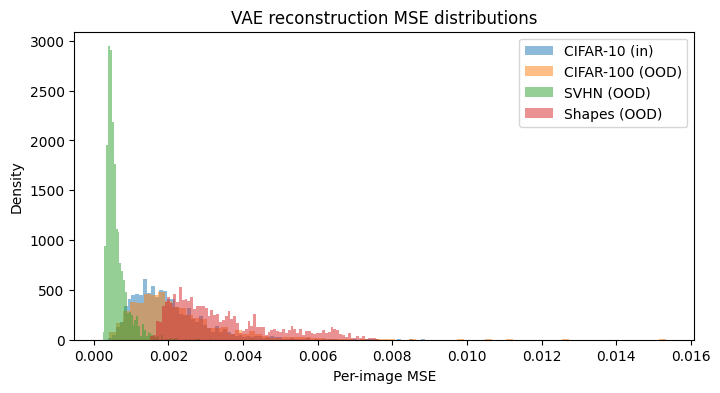

Saved histogram to step2_outputs/vae_mse_in_vs_ood_hist.png
Stats (mean, std, N):
CIFAR-10: (0.0019986105617135763, 0.0010208423482254148, 2000)
CIFAR-100: (0.0022144513204693794, 0.001281888922676444, 2000)
SVHN: (0.0006112042465247214, 0.00032037304481491446, 2000)
Shapes: (0.0034532875288277864, 0.0013988292776048183, 2000)
AUROC (MSE): CIFAR-100 vs CIFAR-10 = 0.5435955000000001
AUROC (MSE): SVHN vs CIFAR-10 = 0.036632999999999985
AUROC (MSE): Shapes vs CIFAR-10 = 0.8304842499999999
AUROC computation failed: name 'json' is not defined
Saved recon pairs to step2_outputs/vae_recon_pairs_cifar100.png


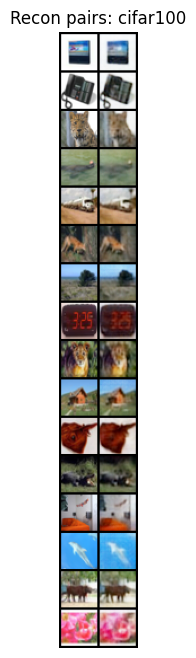

Saved recon pairs to step2_outputs/vae_recon_pairs_svhn.png


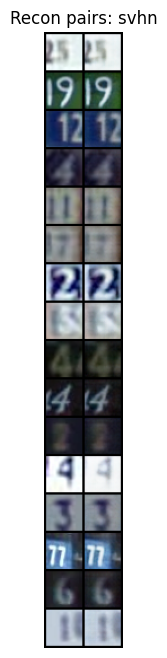

Saved recon pairs to step2_outputs/vae_recon_pairs_shapes.png


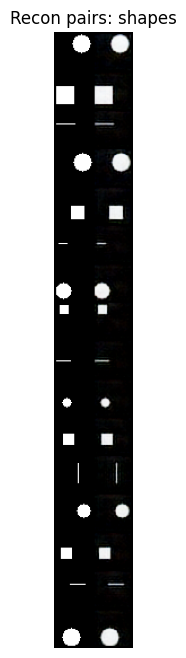

In [36]:
# Parameters
num_examples_show = 16
batch_size = 128
sample_limit = 2000   # number of images for MSE distributions

# Transforms consistent with CIFAR-10 ([-1,1] normalization)
transform_norm = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

# OOD datasets: CIFAR-100, SVHN
cifar100_test = datasets.CIFAR100("./data", train=False, download=True, transform=transform_norm)
svhn_test = datasets.SVHN("./data", split='test', download=True, transform=transform_norm)

# Simple synthetic dataset: circles, squares, lines
def make_synthetic_shapes_dataset(n_samples=2000, size=32):
    import numpy as np
    imgs = []
    for i in range(n_samples):
        canvas = np.zeros((3, size, size), dtype=np.float32)
        shape_type = i % 3
        cx, cy = np.random.randint(6, size-6, size=2)
        s = np.random.randint(4, 10)
        if shape_type == 0:  # circle
            Y, X = np.ogrid[:size, :size]
            mask = (X - cx)**2 + (Y - cy)**2 <= s*s
            canvas[:, mask] = 1.0
        elif shape_type == 1:  # square
            canvas[:, max(0, cy-s):min(size, cy+s), max(0, cx-s):min(size, cx+s)] = 1.0
        else:  # line
            if np.random.rand() < 0.5:
                canvas[:, cy, max(0,cx-s):min(size,cx+s)] = 1.0
            else:
                canvas[:, max(0,cy-s):min(size,cy+s), cx] = 1.0
        imgs.append(torch.tensor(canvas))
    return torch.stack(imgs, dim=0)

synthetic_images = make_synthetic_shapes_dataset(n_samples=2000)

# Compute reconstruction MSE for a loader or tensor
vae.eval()
def compute_recon_mse(loader_or_tensor, max_images=None):
    mses = []
    with torch.no_grad():
        if isinstance(loader_or_tensor, torch.Tensor):  # synthetic
            all_imgs = loader_or_tensor
            all_imgs01 = denorm_img_tensor(all_imgs) if all_imgs.min() < -0.1 else all_imgs
            n = min(max_images or all_imgs01.size(0), all_imgs01.size(0))
            for i in range(0, n, batch_size):
                b = all_imgs01[i:i+batch_size].to(device)
                mu, _ = vae.encode(b)
                recon = vae.decode(mu)
                mses.append(((recon - b)**2).view(b.size(0), -1).mean(dim=1).cpu().numpy())
        else:  # dataset
            collected = 0
            for imgs, _ in loader_or_tensor:
                imgs01 = denorm_img_tensor(imgs).to(device)
                mu, _ = vae.encode(imgs01)
                recon = vae.decode(mu)
                mses.append(((recon - imgs01)**2).view(imgs01.size(0), -1).mean(dim=1).cpu().numpy())
                collected += imgs01.size(0)
                if max_images and collected >= max_images:
                    break
    mses = np.concatenate(mses, axis=0)
    return mses[:max_images] if max_images else mses

# Collect MSE distributions
print("Computing VAE reconstruction MSE...")
mse_cifar10  = compute_recon_mse(testloader, sample_limit)
mse_cifar100 = compute_recon_mse(DataLoader(cifar100_test, batch_size=batch_size), sample_limit)
mse_svhn     = compute_recon_mse(DataLoader(svhn_test, batch_size=batch_size), sample_limit)
mse_shapes   = compute_recon_mse(synthetic_images, sample_limit)

# Plot histograms
plt.figure(figsize=(8,4))
plt.hist(mse_cifar10, bins=80, alpha=0.5, label='CIFAR-10 (in)', density=True)
plt.hist(mse_cifar100, bins=80, alpha=0.5, label='CIFAR-100 (OOD)', density=True)
plt.hist(mse_svhn, bins=80, alpha=0.5, label='SVHN (OOD)', density=True)
plt.hist(mse_shapes, bins=80, alpha=0.5, label='Shapes (OOD)', density=True)
plt.legend(); plt.title('VAE reconstruction MSE distributions')
plt.xlabel('Per-image MSE'); plt.ylabel('Density')
histpath = os.path.join(SAVE_DIR, "vae_mse_in_vs_ood_hist.png")
plt.savefig(histpath, bbox_inches='tight'); plt.show()
print("Saved histogram to", histpath)

# Summary stats
def stats(x): return float(np.mean(x)), float(np.std(x)), int(len(x))
print("Stats (mean, std, N):")
print("CIFAR-10:", stats(mse_cifar10))
print("CIFAR-100:", stats(mse_cifar100))
print("SVHN:", stats(mse_svhn))
print("Shapes:", stats(mse_shapes))

# AUROC using reconstruction MSE
try:
    from sklearn.metrics import roc_auc_score
    def auroc(in_arr, out_arr):
        y_true = np.concatenate([np.zeros(len(in_arr)), np.ones(len(out_arr))])
        scores = np.concatenate([in_arr, out_arr])
        return float(roc_auc_score(y_true, scores))
    auroc_c100  = auroc(mse_cifar10, mse_cifar100)
    auroc_svhn  = auroc(mse_cifar10, mse_svhn)
    auroc_shapes = auroc(mse_cifar10, mse_shapes)
    print("AUROC (MSE): CIFAR-100 vs CIFAR-10 =", auroc_c100)
    print("AUROC (MSE): SVHN vs CIFAR-10 =", auroc_svhn)
    print("AUROC (MSE): Shapes vs CIFAR-10 =", auroc_shapes)

    ood_metrics = {
        "mse_mean": {
            "cifar10": float(mse_cifar10.mean()),
            "cifar100": float(mse_cifar100.mean()),
            "svhn": float(mse_svhn.mean()),
            "shapes": float(mse_shapes.mean())
        },
        "auroc": {
            "cifar100": auroc_c100,
            "svhn": auroc_svhn,
            "shapes": auroc_shapes
        }
    }
    with open(os.path.join(SAVE_DIR, "vae_ood_metrics.json"), "w") as f:
        json.dump(ood_metrics, f)
    print("Saved OOD metrics to", os.path.join(SAVE_DIR, "vae_ood_metrics.json"))
except Exception as e:
    print("AUROC computation failed:", e)

# Save a few example reconstructions (orig vs recon)
def save_recon_pairs(loader_or_tensor, prefix, n_show=16):
    if isinstance(loader_or_tensor, torch.Tensor):
        imgs = loader_or_tensor[:n_show]
    else:
        batch = next(iter(loader_or_tensor))
        imgs = batch[0] if isinstance(batch, (list, tuple)) else batch
        imgs = imgs[:n_show]

    imgs01 = denorm_img_tensor(imgs).to(device)
    with torch.no_grad():
        mu, _ = vae.encode(imgs01)
        recon = vae.decode(mu)

    pairs = []
    for i in range(n_show):
        pairs.append(denorm_img_tensor(imgs[i]).cpu())
        pairs.append(recon[i].cpu())
    pair_batch = torch.stack(pairs, dim=0)

    fname = os.path.join(SAVE_DIR, f"vae_recon_pairs_{prefix}.png")
    save_grid(pair_batch, fname, nrow=2)
    print("Saved recon pairs to", fname)
    show_grid(make_grid(pair_batch, nrow=2), title=f"Recon pairs: {prefix}")

save_recon_pairs(DataLoader(cifar100_test, batch_size=num_examples_show, shuffle=True), "cifar100")
save_recon_pairs(DataLoader(svhn_test, batch_size=num_examples_show, shuffle=True), "svhn")
save_recon_pairs(synthetic_images, "shapes")

### GAN OOD

Saved GAN samples for scale 1.0 -> step2_outputs/gan_scale_1.0.png
Saved GAN samples for scale 2.0 -> step2_outputs/gan_scale_2.0.png
Saved GAN samples for scale 4.0 -> step2_outputs/gan_scale_4.0.png
Saved GAN samples for scale 8.0 -> step2_outputs/gan_scale_8.0.png
Saved GAN samples for scale 16.0 -> step2_outputs/gan_scale_16.0.png
   scale  mean_mean  mean_std  edge_mean
0    1.0   0.396137  0.242440   0.125162
1    2.0   0.502328  0.363208   0.200742
2    4.0   0.494566  0.420534   0.296048
3    8.0   0.464357  0.455616   0.363546
4   16.0   0.420853  0.465910   0.379427
Saved GAN scale stats to step2_outputs/gan_scale_stats.csv


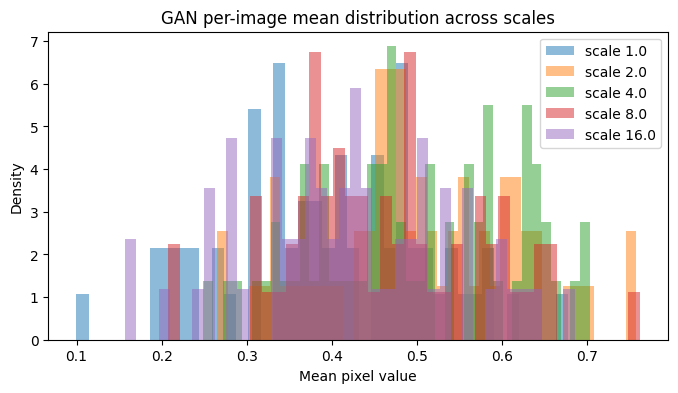

Saved GAN pairwise step MSE stats to step2_outputs/gan_scale_pair_stats.csv
GAN latent scaling analysis complete. Grids, stats, and histograms saved in step2_outputs


In [37]:
scales = [1.0, 2.0, 4.0, 8.0, 16.0]
n_samples = 64   # samples per scale
batch_gen = 64

G.eval()
stats_list = []
all_scale_samples = {}

for s in scales:
    outs = []
    with torch.no_grad():
        for i in range(0, n_samples, batch_gen):
            b = min(batch_gen, n_samples - i)
            z = torch.randn(b, nz, 1, 1, device=device) * s
            imgs = G(z).cpu()   # [-1,1]
            imgs01 = denorm_img_tensor(imgs)  # [0,1]
            outs.append(imgs01)
    all_imgs = torch.cat(outs, dim=0)[:n_samples]  # (n_samples,3,32,32)
    all_scale_samples[s] = all_imgs

    # save grid
    fname = os.path.join(SAVE_DIR, f"gan_scale_{s:.1f}.png")
    save_grid(all_imgs, fname, nrow=8)
    print("Saved GAN samples for scale", s, "->", fname)

    # compute stats
    arr = all_imgs.numpy()  # shape (N,3,H,W)
    means = arr.mean(axis=(1,2,3))
    stds  = arr.std(axis=(1,2,3))
    # edge energy proxy
    edge_energies = []
    for im in arr:
        gray = np.mean(im, axis=0)
        gx = np.abs(np.diff(gray, axis=1)).mean()
        gy = np.abs(np.diff(gray, axis=0)).mean()
        edge_energies.append(gx + gy)
    edge_energies = np.array(edge_energies)

    stats_list.append({
        "scale": float(s),
        "mean_mean": float(means.mean()),
        "mean_std": float(stds.mean()),
        "edge_mean": float(edge_energies.mean())
    })

# Save stats table
import pandas as pd
df_stats = pd.DataFrame(stats_list)
print(df_stats)
df_stats.to_csv(os.path.join(SAVE_DIR, "gan_scale_stats.csv"), index=False)
print("Saved GAN scale stats to", os.path.join(SAVE_DIR, "gan_scale_stats.csv"))

# ================= Histogram comparison =================
plt.figure(figsize=(8,4))
for s in scales:
    arr = all_scale_samples[s].numpy()
    vals = arr.mean(axis=(1,2,3))  # per-image mean
    plt.hist(vals, bins=40, alpha=0.5, label=f"scale {s}", density=True)
plt.legend(); plt.title("GAN per-image mean distribution across scales")
plt.xlabel("Mean pixel value"); plt.ylabel("Density")
plt.savefig(os.path.join(SAVE_DIR, "gan_scale_means_hist.png"), bbox_inches="tight")
plt.show()

# ================= Pairwise scale transition MSE =================
num_pairs = 64
torch.manual_seed(0)
pair_stats = []
zs = torch.randn(num_pairs, nz, 1, 1, device=device)
prev_imgs = None
for s in scales:
    with torch.no_grad():
        imgs = G(zs * s).cpu()
        imgs01 = denorm_img_tensor(imgs)
    if prev_imgs is not None:
        diffs = ((imgs01 - prev_imgs)**2).view(num_pairs, -1).mean(dim=1).numpy()
        pair_stats.append({
            "scale_from": prev_s,
            "scale_to": s,
            "mean_step_mse": float(diffs.mean())
        })
        # histogram
        plt.figure(figsize=(6,3))
        plt.hist(diffs, bins=40, alpha=0.7)
        plt.title(f"Pairwise step MSE: {prev_s} → {s}")
        plt.xlabel("Per-image MSE"); plt.ylabel("Count")
        plt.savefig(os.path.join(SAVE_DIR, f"gan_step_mse_{prev_s}_to_{s}.png"), bbox_inches="tight")
        plt.close()
    prev_imgs = imgs01
    prev_s = s

pd.DataFrame(pair_stats).to_csv(os.path.join(SAVE_DIR, "gan_scale_pair_stats.csv"), index=False)
print("Saved GAN pairwise step MSE stats to", os.path.join(SAVE_DIR, "gan_scale_pair_stats.csv"))
print("GAN latent scaling analysis complete. Grids, stats, and histograms saved in", SAVE_DIR)

### Anomaly detection

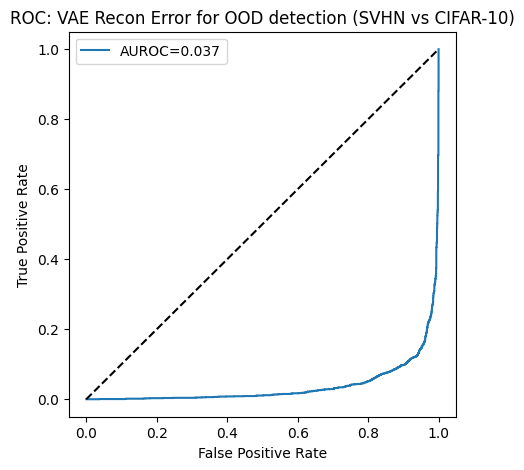

AUROC = 0.036633124999999975
Using threshold=0.0039
Accuracy=0.475, Precision=0.010, Recall=0.001, F1=0.001


In [38]:
vae.eval()

def get_recon_mse(loader, limit=2000):
    mses = []
    with torch.no_grad():
        collected = 0
        for imgs, _ in loader:
            imgs01 = denorm_img_tensor(imgs).to(device)
            mu, _ = vae.encode(imgs01)
            recon = vae.decode(mu)
            per_mse = ((recon - imgs01)**2).view(imgs01.size(0), -1).mean(dim=1).cpu().numpy()
            mses.append(per_mse)
            collected += imgs01.size(0)
            if collected >= limit: break
    return np.concatenate(mses, axis=0)[:limit]

# Collect scores
mse_in  = get_recon_mse(testloader, limit=2000)  # CIFAR-10
mse_out = get_recon_mse(DataLoader(svhn_test, batch_size=128), limit=2000)  # SVHN

#  Build labels + scores
y_true  = np.concatenate([np.zeros_like(mse_in), np.ones_like(mse_out)])  # 0=ID, 1=OOD
scores  = np.concatenate([mse_in, mse_out])

# ROC + AUROC
fpr, tpr, thr = roc_curve(y_true, scores)
auroc = roc_auc_score(y_true, scores)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUROC={auroc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC: VAE Recon Error for OOD detection (SVHN vs CIFAR-10)")
plt.legend(); plt.show()

print("AUROC =", auroc)

# 4) Threshold-based classification example
threshold = np.percentile(mse_in, 95)  # pick 95th percentile of ID as cutoff
y_pred = (scores > threshold).astype(int)
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")

print(f"Using threshold={threshold:.4f}")
print(f"Accuracy={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")